In [23]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [25]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [26]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [27]:
tf.keras.backend.clear_session()

In [28]:
subject = 'Espírito Santo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [29]:
data = pd.read_csv('2003_mo_model_input_ES.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - Consumo de Cimento (t),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,48.426,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,54.969,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,53.847,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,50.375,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,52.576,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


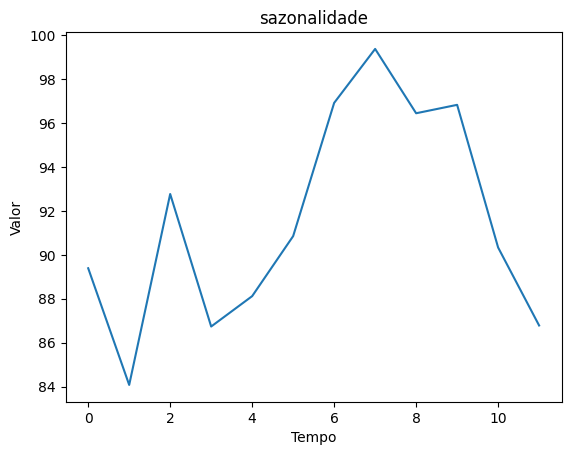

,sazonalidade
sazonalidade,
0,89.389336
1,84.080816
2,92.766791
3,86.737987
4,88.120113
5,90.851233
6,96.911690
7,99.367927
8,96.440882


In [30]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [31]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Espírito Santo - Desemprego,Espírito Santo - IDH,Espírito Santo - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade,Espírito Santo - Consumo de Cimento (t)
0,2003-1,8.177444,0.760059,0.698032,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,4.069229e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,89.389336,48.426
1,2003-2,8.171622,0.760222,0.698295,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,4.094341e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,84.080816,54.969
2,2003-3,8.165799,0.760385,0.698558,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,4.119454e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,92.766791,53.847
3,2003-4,8.159977,0.760548,0.698821,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,4.144566e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,86.737987,50.375
4,2003-5,8.154154,0.760710,0.699084,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,4.169679e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,88.120113,52.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36954.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.120113,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36937.748495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.851233,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36867.947370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.911690,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36784.826883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.367927,NaN


In [32]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.490
1      53.578
2      60.481
3      64.833
4      64.063
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Espírito Santo - Consumo de Cimento (t), Length: 249, dtype: float64

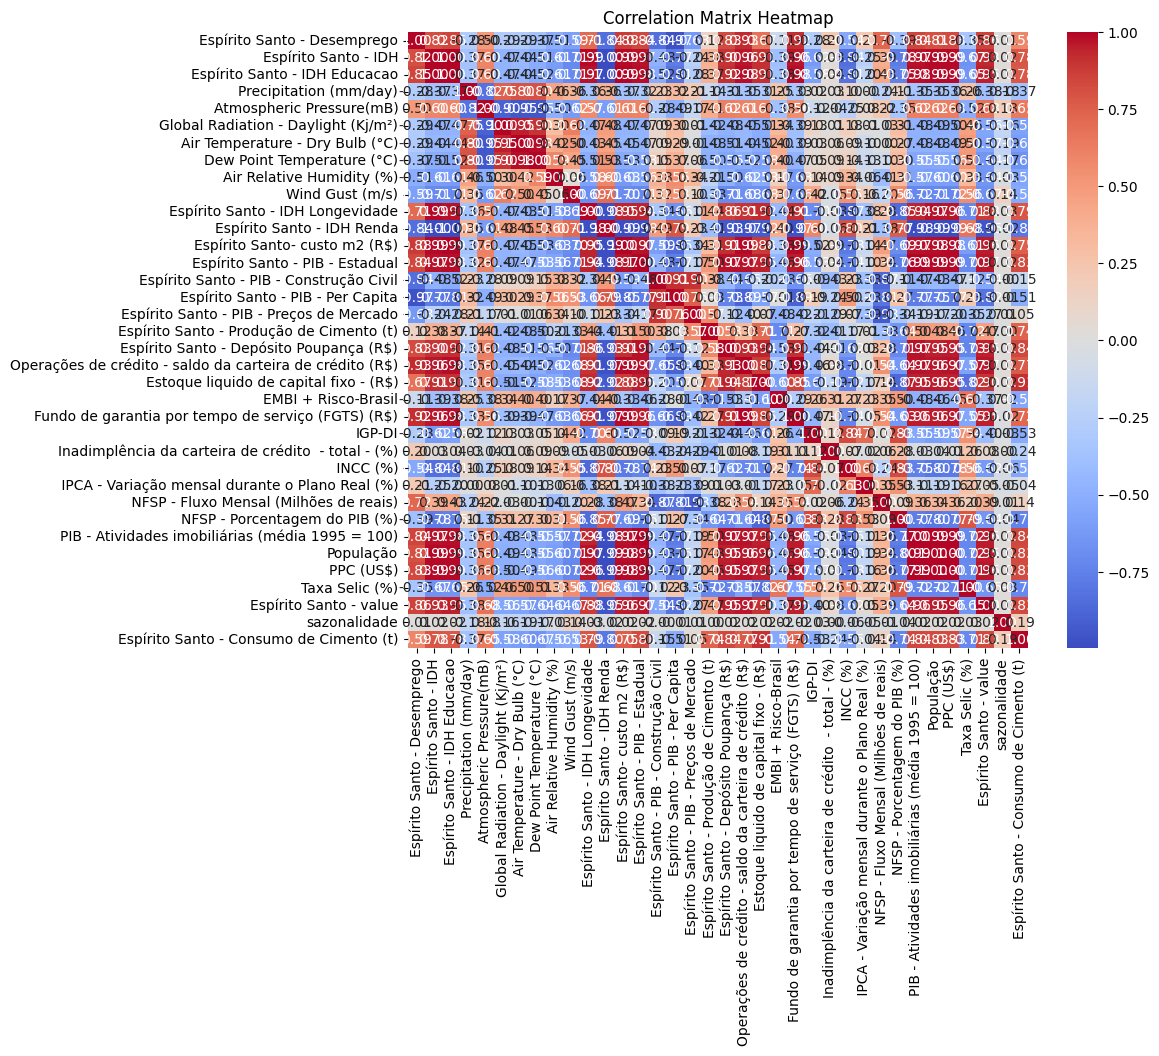

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [35]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Espírito Santo - Desemprego,1.802613e+05
1,Espírito Santo - IDH,3.041764e+05
2,Espírito Santo - IDH Educacao,2.316663e+06
3,Precipitation (mm/day),3.048109e+02
4,Atmospheric Pressure(mB),2.032650e+07
5,Global Radiation - Daylight (Kj/m²),6.734158e+03
6,Air Temperature - Dry Bulb (°C),7.586147e+05
7,Dew Point Temperature (°C),5.214338e+05
8,Air Relative Humidity (%),5.019415e+05
9,Wind Gust (m/s),2.932094e+03


In [36]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Espírito Santo - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value,sazonalidade
0,8.177444,1.637986,1014.886326,1430.287676,24.394984,19.768291,76.995517,2.181755,0.840524,0.757615,10264.686400,6.342537e+07,3.523987e+06,16.799308,98.171240,4.069229e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.268445,89.389336
1,8.171622,1.638486,1014.889937,1430.121567,24.394230,19.767196,76.994127,2.180648,0.840977,0.757416,10362.759477,6.350834e+07,3.527412e+06,16.807398,97.897317,4.094341e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.270512,84.080816
2,8.165799,1.638778,1014.892043,1430.024670,24.393791,19.766557,76.993316,2.180003,0.841429,0.757217,10458.009107,6.359131e+07,3.530838e+06,16.815488,98.070539,4.119454e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.271941,92.766791
3,8.159977,1.638809,1014.892268,1430.014288,24.393743,19.766489,76.993229,2.179934,0.841882,0.757018,10551.050535,6.367428e+07,3.534263e+06,16.823577,98.460789,4.144566e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.273321,86.737987
4,8.154154,1.655341,1014.807407,1434.131772,24.464335,19.846793,77.041977,2.180096,0.842335,0.756819,10642.401914,6.375725e+07,3.537689e+06,16.831667,99.084134,4.169679e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.274453,88.120113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,10.327823,1.172889,1018.685248,1275.189799,22.719168,18.320890,75.020513,1.700700,0.878050,0.731113,24908.935717,7.287388e+07,3.502700e+06,16.535554,102.625990,8.139321e+06,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,0.371395,99.367927
176,10.310550,1.391585,1017.552160,1311.414663,23.386392,18.927588,74.766006,1.767781,0.877950,0.731142,24997.157902,7.289170e+07,3.504094e+06,16.541044,99.969898,8.173259e+06,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,0.371461,96.440882
177,10.293277,1.510629,1015.906154,1399.424597,24.247200,19.502408,73.862730,1.855212,0.877849,0.731172,25084.406791,7.290952e+07,3.505489e+06,16.546534,97.572861,8.207198e+06,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,0.371526,96.823849
178,10.276004,1.654470,1014.871439,1404.358085,24.697764,20.006842,73.884726,1.800783,0.877749,0.731202,25171.972731,7.292733e+07,3.506884e+06,16.552023,94.929951,8.241137e+06,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989

In [37]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-0.555700,0.017479,-0.131402,-0.361828,-0.323639,0.013516,1.303655,-2.332996,1.874097,-1.572435,-1.872410,-1.010041,0.011508,-1.540384,-1.642291,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.234089
1,-0.554410,0.018852,-0.132421,-0.362231,-0.324175,0.012825,1.297936,-2.287754,1.849100,-1.550329,-1.844997,-0.959209,0.051647,-1.547448,-1.626192,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.185528
2,-0.553657,0.019653,-0.133016,-0.362466,-0.324488,0.012423,1.294600,-2.242512,1.824102,-1.528860,-1.817583,-0.908378,0.091786,-1.542981,-1.610094,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-1.151932
3,-0.553577,0.019739,-0.133080,-0.362491,-0.324521,0.012380,1.294242,-2.197270,1.799105,-1.507888,-1.790169,-0.857547,0.131925,-1.532917,-1.593996,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-1.119518
4,-0.510904,-0.012536,-0.107817,-0.324778,-0.285239,0.036587,1.295079,-2.152028,1.774107,-1.487298,-1.762755,-0.806715,0.172064,-1.516842,-1.577897,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-1.092919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.756238,1.462301,-1.083008,-1.257124,-1.031666,-0.967247,-1.183096,1.417539,-1.454422,1.728384,1.249405,-1.325920,-1.297143,-1.425502,0.966836,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.184936
176,-1.191727,1.031360,-0.860749,-0.900664,-0.734887,-1.093632,-0.836332,1.407508,-1.450706,1.748269,1.255291,-1.305224,-1.269905,-1.493999,0.988592,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.186489
177,-0.884443,0.405344,-0.320763,-0.440781,-0.453701,-1.542187,-0.384367,1.397478,-1.446990,1.767935,1.261178,-1.284529,-1.242668,-1.555816,1.010349,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.188015
178,-0.513150,0.011817,-0.290494,-0.200070,-0.206947,-1.531264,-0.665728,1.387447,-1.443274,1.787673,1.267064,-1.263833,-1.215430,-1.623973,1.032105,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,1.189518


In [38]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
0,-0.555700,0.017479,-0.131402,-0.361828,-0.323639,0.013516,1.303655,-2.332996,1.874097,-1.572435,-1.872410,-1.010041,0.011508,-1.540384,-1.642291,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.234089
1,-0.554410,0.018852,-0.132421,-0.362231,-0.324175,0.012825,1.297936,-2.287754,1.849100,-1.550329,-1.844997,-0.959209,0.051647,-1.547448,-1.626192,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.185528
2,-0.553657,0.019653,-0.133016,-0.362466,-0.324488,0.012423,1.294600,-2.242512,1.824102,-1.528860,-1.817583,-0.908378,0.091786,-1.542981,-1.610094,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-1.151932
3,-0.553577,0.019739,-0.133080,-0.362491,-0.324521,0.012380,1.294242,-2.197270,1.799105,-1.507888,-1.790169,-0.857547,0.131925,-1.532917,-1.593996,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-1.119518
4,-0.510904,-0.012536,-0.107817,-0.324778,-0.285239,0.036587,1.295079,-2.152028,1.774107,-1.487298,-1.762755,-0.806715,0.172064,-1.516842,-1.577897,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-1.092919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-1.101850,0.995585,-1.038156,-0.758913,-0.840027,-0.681181,-0.894236,1.516373,-1.480024,1.490528,1.154955,-1.517461,-1.601162,-0.661324,0.754495,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.145319
164,-1.239815,0.633961,-0.865197,-0.501018,-0.573050,-0.537420,-0.612140,1.510649,-1.480106,1.512662,1.165603,-1.508127,-1.578491,-0.725525,0.766504,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,1.151390
165,-0.134148,0.291961,-0.357841,-0.155358,-0.330589,-0.793708,-0.272588,1.504925,-1.480188,1.534749,1.176252,-1.498793,-1.555821,-0.789018,0.778514,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.157082
166,0.085501,0.070008,0.069764,0.168684,-0.070764,-0.876558,-0.232967,1.499200,-1.480271,1.556602,1.186901,-1.489458,-1.533150,-0.850802,0.790523,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,1.165365


In [39]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.490
1       53.578
2       60.481
3       64.833
4       64.063
        ...   
163    107.106
164    101.893
165    110.551
166    100.587
167     94.220
Name: Espírito Santo - Consumo de Cimento (t), Length: 168, dtype: float64

In [40]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Espírito Santo - IDH Longevidade,Espírito Santo - IDH Renda,Espírito Santo- custo m2 (R$),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - Produção de Cimento (t),Espírito Santo - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Espírito Santo - value
168,0.059023,-0.029343,0.382136,0.467435,0.021597,-1.560876,-0.429821,1.487752,-1.480435,1.595764,1.208199,-1.470790,-1.487808,-0.976748,0.814541,1.376932,0.146258,1.774331,-1.414596,1.544952,-1.619756,-1.269571,0.705135,-0.643748,1.133345,1.287235,1.337633,-0.848841,1.172458
169,-0.682309,0.119169,-0.229696,0.180864,-0.057362,-0.793529,-1.139845,1.477721,-1.476719,1.614675,1.214086,-1.450094,-1.460570,-1.040923,0.836297,1.372955,0.069548,1.603011,-1.326123,1.687834,-1.703430,-1.318025,1.050348,-0.639696,1.154937,1.298856,1.349730,-0.710205,1.174309
170,-0.586302,0.415258,-0.624413,-0.120660,-0.255202,-0.597665,-1.497596,1.467691,-1.473003,1.633590,1.219972,-1.429398,-1.433333,-1.098434,0.858054,1.369449,-0.001029,1.566915,-1.203988,1.921399,-1.791187,-1.274124,0.891008,-0.633632,1.176530,1.310477,1.361535,-0.663329,1.177536
171,-0.675101,1.094612,-1.294917,-0.678624,-0.473729,0.252932,-2.054643,1.457660,-1.469287,1.651950,1.225859,-1.408703,-1.406095,-1.170638,0.879810,1.367904,-0.050763,1.509198,-1.033667,1.919191,-1.781750,-1.249228,0.718432,-0.626158,1.198123,1.322098,1.373539,-0.742310,1.179784
172,-0.915131,1.494798,-1.509500,-1.152682,-0.804252,0.313224,-2.262167,1.447630,-1.465570,1.670649,1.231745,-1.388007,-1.378857,-1.232742,0.901567,1.363452,-0.088103,1.510496,-0.794607,1.810466,-1.799478,-1.298144,0.870539,-0.617303,1.214047,1.333718,1.385370,-1.220021,1.181034
173,-1.325872,1.940590,-1.477851,-1.406237,-0.998811,-0.012491,-2.149312,1.437599,-1.461854,1.689702,1.237632,-1.367311,-1.351619,-1.297339,0.923323,1.359511,-0.122336,1.513850,-0.626344,1.568703,-1.782843,-1.416414,0.707986,-0.607822,1.229972,1.345339,1.397504,0.082610,1.181741
174,-1.638492,1.954300,-1.300952,-1.446935,-1.072367,-0.404886,-1.657759,1.427569,-1.458138,1.709311,1.243518,-1.346616,-1.324381,-1.359805,0.945080,1.352561,-0.149882,1.502535,-0.480760,1.414649,-1.870854,-1.358337,0.499926,-0.597435,1.245897,1.356960,1.409256,-1.207352,1.183354
175,-1.756238,1.462301,-1.083008,-1.257124,-1.031666,-0.967247,-1.183096,1.417539,-1.454422,1.728384,1.249405,-1.325920,-1.297143,-1.425502,0.966836,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.184936
176,-1.191727,1.031360,-0.860749,-0.900664,-0.734887,-1.093632,-0.836332,1.407508,-1.450706,1.748269,1.255291,-1.305224,-1.269905,-1.493999,0.988592,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.186489
177,-0.884443,0.405344,-0.320763,-0.440781,-0.453701,-1.542187,-0.384367,1.397478,-1.446990,1.767935,1.261178,-1.284529,-1.242668,-1.555816,1.010349,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.188015


In [41]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    111.377
169     98.614
170     94.022
171     91.546
172     95.674
173     88.927
174    105.688
175    104.711
176     97.530
177     99.651
178     76.710
179     75.456
Name: Espírito Santo - Consumo de Cimento (t), dtype: float64

In [42]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [43]:
def get_a_good_seed(train_input, train_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = neural_network_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")

    return winner_seed

In [44]:
winner_seed = get_a_good_seed(train_input, train_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1542427472, 2286350409, 1059639499, 261592721, 837698922, 623136769, 3012929364, 4243458384, 412648360, 375129461]


Step: 0 ___________________________________________


2023-11-20 19:08:29.162707: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


val_loss: 141.28097534179688
winner_seed: 1542427472


Step: 1 ___________________________________________
val_loss: 165.60899353027344


Step: 2 ___________________________________________
val_loss: 198.3725128173828


Step: 3 ___________________________________________
val_loss: 145.60423278808594


Step: 4 ___________________________________________
val_loss: 124.0070571899414
winner_seed: 837698922


Step: 5 ___________________________________________
val_loss: 179.9142303466797


Step: 6 ___________________________________________
val_loss: 204.4974822998047


Step: 7 ___________________________________________
val_loss: 178.5680389404297


Step: 8 ___________________________________________
val_loss: 301.51312255859375


Step: 9 ___________________________________________
val_loss: 157.81639099121094


final_seed: 837698922


In [45]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 1s 28ms/step - loss: 8365.4268 - val_loss: 18467.3848
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 6652.8315 - val_loss: 1927.7489
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 4816.2124 - val_loss: 13185.0615
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 2363.8550 - val_loss: 7798.9194
Epoch 5/10000
5/5 [==============================] - 0s 7ms/step - loss: 331.8435 - val_loss: 326.0569
Epoch 6/10000
5/5 [==============================] - 0s 7ms/step - loss: 127.5684 - val_loss: 246.3400
Epoch 7/10000
5/5 [==============================] - 0s 5ms/step - loss: 113.2606 - val_loss: 252.8368
Epoch 8/10000
5/5 [==============================] - 0s 6ms/step - loss: 106.4792 - val_loss: 253.4760
Epoch 9/10000
5/5 [==============================] - 0s 6ms/step - loss: 114.0877 - val_loss: 344.9062
Epoch 10/10000
5/5 [==============================] - 0s 6ms/s

5/5 [==============================] - 0s 6ms/step - loss: 64.7565 - val_loss: 284.6806
Epoch 81/10000
5/5 [==============================] - 0s 6ms/step - loss: 68.8242 - val_loss: 275.1599
Epoch 82/10000
5/5 [==============================] - 0s 6ms/step - loss: 66.9548 - val_loss: 374.0243
Epoch 83/10000
5/5 [==============================] - 0s 6ms/step - loss: 69.4410 - val_loss: 539.2678
Epoch 84/10000
5/5 [==============================] - 0s 6ms/step - loss: 67.7920 - val_loss: 433.8536
Epoch 85/10000
5/5 [==============================] - 0s 6ms/step - loss: 68.5177 - val_loss: 742.0093
Epoch 86/10000
5/5 [==============================] - 0s 6ms/step - loss: 64.7778 - val_loss: 442.9912
Epoch 87/10000
5/5 [==============================] - 0s 6ms/step - loss: 64.4672 - val_loss: 596.2424
Epoch 88/10000
5/5 [==============================] - 0s 6ms/step - loss: 64.4952 - val_loss: 443.1223
Epoch 89/10000
5/5 [==============================] - 0s 6ms/step - loss: 65.7210 - val_

5/5 [==============================] - 0s 6ms/step - loss: 62.6042 - val_loss: 377.4915
Epoch 160/10000
5/5 [==============================] - 0s 6ms/step - loss: 59.6366 - val_loss: 376.2123
Epoch 161/10000
5/5 [==============================] - 0s 6ms/step - loss: 62.5155 - val_loss: 246.1897
Epoch 162/10000
5/5 [==============================] - 0s 6ms/step - loss: 63.0818 - val_loss: 233.1258
Epoch 163/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.0447 - val_loss: 214.7370
Epoch 164/10000
5/5 [==============================] - 0s 6ms/step - loss: 62.2986 - val_loss: 290.4690
Epoch 165/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.5135 - val_loss: 241.5345
Epoch 166/10000
5/5 [==============================] - 0s 6ms/step - loss: 58.1990 - val_loss: 243.2166
Epoch 167/10000
5/5 [==============================] - 0s 6ms/step - loss: 55.4536 - val_loss: 238.0319
Epoch 168/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.61

Epoch 238/10000
5/5 [==============================] - 0s 6ms/step - loss: 59.0424 - val_loss: 411.5376
Epoch 239/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.5484 - val_loss: 472.5690
Epoch 240/10000
5/5 [==============================] - 0s 6ms/step - loss: 54.4511 - val_loss: 510.8104
Epoch 241/10000
5/5 [==============================] - 0s 6ms/step - loss: 64.9671 - val_loss: 189.6359
Epoch 242/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.8221 - val_loss: 210.9050
Epoch 243/10000
5/5 [==============================] - 0s 6ms/step - loss: 57.3727 - val_loss: 192.6381
Epoch 244/10000
5/5 [==============================] - 0s 6ms/step - loss: 53.5195 - val_loss: 195.4126
Epoch 245/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.1315 - val_loss: 188.4036
Epoch 246/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.8077 - val_loss: 187.6048
Epoch 247/10000
5/5 [==============================] - 0s 6ms/st

Epoch 317/10000
5/5 [==============================] - 0s 6ms/step - loss: 59.0020 - val_loss: 185.9097
Epoch 318/10000
5/5 [==============================] - 0s 6ms/step - loss: 53.4831 - val_loss: 190.3980
Epoch 319/10000
5/5 [==============================] - 0s 6ms/step - loss: 49.5759 - val_loss: 191.2691
Epoch 320/10000
5/5 [==============================] - 0s 6ms/step - loss: 52.2936 - val_loss: 187.5059
Epoch 321/10000
5/5 [==============================] - 0s 6ms/step - loss: 56.6238 - val_loss: 192.1517
Epoch 322/10000
5/5 [==============================] - 0s 6ms/step - loss: 58.7412 - val_loss: 193.6017
Epoch 323/10000
5/5 [==============================] - 0s 7ms/step - loss: 55.6334 - val_loss: 196.6359
Epoch 324/10000
5/5 [==============================] - 0s 6ms/step - loss: 51.2248 - val_loss: 198.8820
Epoch 325/10000
5/5 [==============================] - 0s 7ms/step - loss: 54.2290 - val_loss: 196.9877
Epoch 326/10000
5/5 [==============================] - 0s 6ms/st

Epoch 396/10000
5/5 [==============================] - 0s 11ms/step - loss: 47.6545 - val_loss: 190.4375
Epoch 397/10000
5/5 [==============================] - 0s 6ms/step - loss: 47.9169 - val_loss: 187.9800
Epoch 398/10000
5/5 [==============================] - 0s 6ms/step - loss: 64.2106 - val_loss: 207.5087
Epoch 399/10000
5/5 [==============================] - 0s 6ms/step - loss: 54.9909 - val_loss: 206.4697
Epoch 400/10000
5/5 [==============================] - 0s 6ms/step - loss: 52.0196 - val_loss: 192.7852
Epoch 401/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.8951 - val_loss: 194.2525
Epoch 402/10000
5/5 [==============================] - 0s 6ms/step - loss: 51.3386 - val_loss: 198.2706
Epoch 403/10000
5/5 [==============================] - 0s 5ms/step - loss: 50.5141 - val_loss: 194.3535
Epoch 404/10000
5/5 [==============================] - 0s 6ms/step - loss: 48.7945 - val_loss: 194.1913
Epoch 405/10000
5/5 [==============================] - 0s 6ms/s

5/5 [==============================] - 0s 6ms/step - loss: 47.0877 - val_loss: 189.7795
Epoch 475/10000
5/5 [==============================] - 0s 7ms/step - loss: 46.0620 - val_loss: 188.6734
Epoch 476/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.9774 - val_loss: 189.8868
Epoch 477/10000
5/5 [==============================] - 0s 6ms/step - loss: 47.5917 - val_loss: 187.5782
Epoch 478/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.2704 - val_loss: 190.3521
Epoch 479/10000
5/5 [==============================] - 0s 6ms/step - loss: 44.5853 - val_loss: 193.1985
Epoch 480/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.7645 - val_loss: 194.7952
Epoch 481/10000
5/5 [==============================] - 0s 6ms/step - loss: 44.8329 - val_loss: 197.2025
Epoch 482/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.4823 - val_loss: 192.1244
Epoch 483/10000
5/5 [==============================] - 0s 7ms/step - loss: 47.71

Epoch 553/10000
5/5 [==============================] - 0s 6ms/step - loss: 42.8469 - val_loss: 192.8802
Epoch 554/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.9812 - val_loss: 191.4053
Epoch 555/10000
5/5 [==============================] - 0s 6ms/step - loss: 49.5390 - val_loss: 194.8459
Epoch 556/10000
5/5 [==============================] - 0s 6ms/step - loss: 46.7063 - val_loss: 197.3847
Epoch 557/10000
5/5 [==============================] - 0s 6ms/step - loss: 47.0380 - val_loss: 192.5864
Epoch 558/10000
5/5 [==============================] - 0s 6ms/step - loss: 45.8356 - val_loss: 193.7377
Epoch 559/10000
5/5 [==============================] - 0s 94ms/step - loss: 44.5529 - val_loss: 194.5585
Epoch 560/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.9414 - val_loss: 190.5385
Epoch 561/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.1310 - val_loss: 189.3704
Epoch 562/10000
5/5 [==============================] - 0s 6ms/s

Epoch 632/10000
5/5 [==============================] - 0s 6ms/step - loss: 40.3816 - val_loss: 193.7559
Epoch 633/10000
5/5 [==============================] - 0s 6ms/step - loss: 42.7182 - val_loss: 188.4780
Epoch 634/10000
5/5 [==============================] - 0s 6ms/step - loss: 44.7696 - val_loss: 199.1586
Epoch 635/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.7973 - val_loss: 207.2289
Epoch 636/10000
5/5 [==============================] - 0s 6ms/step - loss: 42.8909 - val_loss: 193.7070
Epoch 637/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.3391 - val_loss: 198.3451
Epoch 638/10000
5/5 [==============================] - 0s 7ms/step - loss: 43.8206 - val_loss: 196.3012
Epoch 639/10000
5/5 [==============================] - 0s 6ms/step - loss: 46.3707 - val_loss: 197.6705
Epoch 640/10000
5/5 [==============================] - 0s 11ms/step - loss: 43.2368 - val_loss: 199.5788
Epoch 641/10000
5/5 [==============================] - 0s 7ms/s

5/5 [==============================] - 0s 6ms/step - loss: 42.9781 - val_loss: 207.8685
Epoch 711/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.2133 - val_loss: 219.8338
Epoch 712/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.3655 - val_loss: 201.5322
Epoch 713/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.1105 - val_loss: 221.1612
Epoch 714/10000
5/5 [==============================] - 0s 6ms/step - loss: 41.3328 - val_loss: 225.8298
Epoch 715/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.7325 - val_loss: 208.4613
Epoch 716/10000
5/5 [==============================] - 0s 6ms/step - loss: 40.1093 - val_loss: 210.6483
Epoch 717/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.5512 - val_loss: 211.5433
Epoch 718/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.4263 - val_loss: 204.0598
Epoch 719/10000
5/5 [==============================] - 0s 11ms/step - loss: 39.9

Epoch 789/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.8986 - val_loss: 206.2050
Epoch 790/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.1362 - val_loss: 206.0084
Epoch 791/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.8594 - val_loss: 208.9474
Epoch 792/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.5022 - val_loss: 202.3820
Epoch 793/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.1445 - val_loss: 192.9145
Epoch 794/10000
5/5 [==============================] - 0s 6ms/step - loss: 41.5844 - val_loss: 205.7556
Epoch 795/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.8853 - val_loss: 202.8488
Epoch 796/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.0854 - val_loss: 197.4642
Epoch 797/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.6869 - val_loss: 210.4589
Epoch 798/10000
5/5 [==============================] - 0s 6ms/st

Epoch 868/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.0622 - val_loss: 188.3706
Epoch 869/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.1071 - val_loss: 184.3368
Epoch 870/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.6939 - val_loss: 191.5302
Epoch 871/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.9149 - val_loss: 199.6063
Epoch 872/10000
5/5 [==============================] - 0s 7ms/step - loss: 42.3853 - val_loss: 196.0587
Epoch 873/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.1489 - val_loss: 188.1583
Epoch 874/10000
5/5 [==============================] - 0s 6ms/step - loss: 48.1893 - val_loss: 191.6369
Epoch 875/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.0705 - val_loss: 195.1263
Epoch 876/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.3131 - val_loss: 191.8354
Epoch 877/10000
5/5 [==============================] - 0s 7ms/st

Epoch 947/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.5033 - val_loss: 201.9326
Epoch 948/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.9856 - val_loss: 206.3526
Epoch 949/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.2303 - val_loss: 193.2059
Epoch 950/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.9700 - val_loss: 187.2616
Epoch 951/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.1759 - val_loss: 194.4552
Epoch 952/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.4846 - val_loss: 241.7118
Epoch 953/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.2359 - val_loss: 202.9154
Epoch 954/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.6065 - val_loss: 204.5621
Epoch 955/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.7286 - val_loss: 207.7283
Epoch 956/10000
5/5 [==============================] - 0s 7ms/st

5/5 [==============================] - 0s 6ms/step - loss: 37.1714 - val_loss: 188.7124
Epoch 1026/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.4706 - val_loss: 196.6408
Epoch 1027/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.7257 - val_loss: 202.1721
Epoch 1028/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.9556 - val_loss: 202.2723
Epoch 1029/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.6002 - val_loss: 199.8027
Epoch 1030/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.4217 - val_loss: 196.5676
Epoch 1031/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.6167 - val_loss: 191.5408
Epoch 1032/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.7695 - val_loss: 194.2131
Epoch 1033/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.6557 - val_loss: 197.8042
Epoch 1034/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 39.4582 - val_loss: 204.6680
Epoch 1104/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.0775 - val_loss: 205.4347
Epoch 1105/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.9289 - val_loss: 195.3780
Epoch 1106/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.7494 - val_loss: 201.0411
Epoch 1107/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.9279 - val_loss: 194.3748
Epoch 1108/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.2354 - val_loss: 186.3643
Epoch 1109/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.5140 - val_loss: 187.4575
Epoch 1110/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.7574 - val_loss: 187.4489
Epoch 1111/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.8138 - val_loss: 189.6775
Epoch 1112/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 37.7153 - val_loss: 188.8364
Epoch 1182/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.5203 - val_loss: 183.9206
Epoch 1183/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.8808 - val_loss: 180.9361
Epoch 1184/10000
5/5 [==============================] - 0s 6ms/step - loss: 38.0333 - val_loss: 191.1109
Epoch 1185/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.9545 - val_loss: 190.2347
Epoch 1186/10000
5/5 [==============================] - 0s 6ms/step - loss: 37.5380 - val_loss: 188.6105
Epoch 1187/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.9353 - val_loss: 186.8300
Epoch 1188/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.2783 - val_loss: 181.1275
Epoch 1189/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.7098 - val_loss: 185.5164
Epoch 1190/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 40.5189 - val_loss: 192.8635
Epoch 1260/10000
5/5 [==============================] - 0s 6ms/step - loss: 43.3726 - val_loss: 206.3517
Epoch 1261/10000
5/5 [==============================] - 0s 6ms/step - loss: 41.3875 - val_loss: 199.8837
Epoch 1262/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.8499 - val_loss: 196.1970
Epoch 1263/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.9635 - val_loss: 205.3734
Epoch 1264/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.6072 - val_loss: 206.7772
Epoch 1265/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.0402 - val_loss: 196.0209
Epoch 1266/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.7310 - val_loss: 201.1680
Epoch 1267/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.3759 - val_loss: 193.4825
Epoch 1268/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 33.6787 - val_loss: 222.2001
Epoch 1338/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.2478 - val_loss: 240.9993
Epoch 1339/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.6719 - val_loss: 226.2246
Epoch 1340/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.9448 - val_loss: 240.6517
Epoch 1341/10000
5/5 [==============================] - 0s 7ms/step - loss: 49.0806 - val_loss: 242.5486
Epoch 1342/10000
5/5 [==============================] - 0s 7ms/step - loss: 47.2595 - val_loss: 220.9081
Epoch 1343/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.1154 - val_loss: 224.1854
Epoch 1344/10000
5/5 [==============================] - 0s 6ms/step - loss: 34.8072 - val_loss: 208.2631
Epoch 1345/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.3230 - val_loss: 210.6371
Epoch 1346/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 36.0989 - val_loss: 213.7826
Epoch 1416/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.4868 - val_loss: 201.7667
Epoch 1417/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.9372 - val_loss: 205.8309
Epoch 1418/10000
5/5 [==============================] - 0s 6ms/step - loss: 32.7718 - val_loss: 201.6578
Epoch 1419/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.9614 - val_loss: 205.3775
Epoch 1420/10000
5/5 [==============================] - 0s 6ms/step - loss: 34.2319 - val_loss: 187.3356
Epoch 1421/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.7345 - val_loss: 188.9222
Epoch 1422/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.2636 - val_loss: 183.9908
Epoch 1423/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.8054 - val_loss: 184.7401
Epoch 1424/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 35.1252 - val_loss: 192.7087
Epoch 1494/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.3011 - val_loss: 180.9841
Epoch 1495/10000
5/5 [==============================] - 0s 6ms/step - loss: 31.4188 - val_loss: 180.5291
Epoch 1496/10000
5/5 [==============================] - 0s 6ms/step - loss: 39.6755 - val_loss: 179.6305
Epoch 1497/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.7405 - val_loss: 197.9191
Epoch 1498/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.8246 - val_loss: 175.9521
Epoch 1499/10000
5/5 [==============================] - 0s 7ms/step - loss: 31.3983 - val_loss: 173.0642
Epoch 1500/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.1332 - val_loss: 187.9424
Epoch 1501/10000
5/5 [==============================] - 0s 6ms/step - loss: 29.3349 - val_loss: 184.5875
Epoch 1502/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 31.7327 - val_loss: 178.1607
Epoch 1572/10000
5/5 [==============================] - 0s 6ms/step - loss: 32.1383 - val_loss: 182.0054
Epoch 1573/10000
5/5 [==============================] - 0s 6ms/step - loss: 36.8218 - val_loss: 178.7970
Epoch 1574/10000
5/5 [==============================] - 0s 6ms/step - loss: 29.4664 - val_loss: 167.1651
Epoch 1575/10000
5/5 [==============================] - 0s 7ms/step - loss: 33.6666 - val_loss: 174.8247
Epoch 1576/10000
5/5 [==============================] - 0s 7ms/step - loss: 36.5329 - val_loss: 181.9411
Epoch 1577/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.4589 - val_loss: 179.7444
Epoch 1578/10000
5/5 [==============================] - 0s 6ms/step - loss: 33.7877 - val_loss: 177.8408
Epoch 1579/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.9092 - val_loss: 174.8908
Epoch 1580/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 35.3404 - val_loss: 174.2950
Epoch 1650/10000
5/5 [==============================] - 0s 7ms/step - loss: 32.0327 - val_loss: 165.2487
Epoch 1651/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.0462 - val_loss: 165.6954
Epoch 1652/10000
5/5 [==============================] - 0s 7ms/step - loss: 34.6914 - val_loss: 165.9750
Epoch 1653/10000
5/5 [==============================] - 0s 6ms/step - loss: 34.0088 - val_loss: 166.6875
Epoch 1654/10000
5/5 [==============================] - 0s 8ms/step - loss: 30.7052 - val_loss: 167.6024
Epoch 1655/10000
5/5 [==============================] - 0s 6ms/step - loss: 35.6936 - val_loss: 168.6922
Epoch 1656/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.8560 - val_loss: 169.7579
Epoch 1657/10000
5/5 [==============================] - 0s 7ms/step - loss: 29.8679 - val_loss: 170.4245
Epoch 1658/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 24.5139 - val_loss: 160.9690
Epoch 1728/10000
5/5 [==============================] - 0s 11ms/step - loss: 24.4502 - val_loss: 158.1419
Epoch 1729/10000
5/5 [==============================] - 0s 6ms/step - loss: 24.5816 - val_loss: 163.2508
Epoch 1730/10000
5/5 [==============================] - 0s 6ms/step - loss: 27.1604 - val_loss: 158.3826
Epoch 1731/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.7690 - val_loss: 159.5376
Epoch 1732/10000
5/5 [==============================] - 0s 6ms/step - loss: 23.8595 - val_loss: 156.7371
Epoch 1733/10000
5/5 [==============================] - 0s 6ms/step - loss: 25.0754 - val_loss: 161.3829
Epoch 1734/10000
5/5 [==============================] - 0s 6ms/step - loss: 28.2245 - val_loss: 161.1234
Epoch 1735/10000
5/5 [==============================] - 0s 11ms/step - loss: 27.8761 - val_loss: 164.7771
Epoch 1736/10000
5/5 [==============================] - 0s 6ms/step - 

5/5 [==============================] - 0s 6ms/step - loss: 28.5190 - val_loss: 158.2946
Epoch 1806/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.5751 - val_loss: 155.7105
Epoch 1807/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.9696 - val_loss: 153.8964
Epoch 1808/10000
5/5 [==============================] - 0s 7ms/step - loss: 30.9212 - val_loss: 152.9637
Epoch 1809/10000
5/5 [==============================] - 0s 7ms/step - loss: 30.6931 - val_loss: 162.3008
Epoch 1810/10000
5/5 [==============================] - 0s 6ms/step - loss: 27.7824 - val_loss: 160.0586
Epoch 1811/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.7959 - val_loss: 165.4091
Epoch 1812/10000
5/5 [==============================] - 0s 6ms/step - loss: 25.4059 - val_loss: 161.5955
Epoch 1813/10000
5/5 [==============================] - 0s 6ms/step - loss: 29.3549 - val_loss: 170.7660
Epoch 1814/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 23.9124 - val_loss: 159.8111
Epoch 1884/10000
5/5 [==============================] - 0s 6ms/step - loss: 26.8310 - val_loss: 155.4881
Epoch 1885/10000
5/5 [==============================] - 0s 6ms/step - loss: 26.4531 - val_loss: 155.8706
Epoch 1886/10000
5/5 [==============================] - 0s 7ms/step - loss: 27.1897 - val_loss: 151.1523
Epoch 1887/10000
5/5 [==============================] - 0s 7ms/step - loss: 26.7646 - val_loss: 153.9712
Epoch 1888/10000
5/5 [==============================] - 0s 6ms/step - loss: 29.5791 - val_loss: 156.4425
Epoch 1889/10000
5/5 [==============================] - 0s 6ms/step - loss: 27.7899 - val_loss: 154.7789
Epoch 1890/10000
5/5 [==============================] - 0s 6ms/step - loss: 24.6940 - val_loss: 154.4013
Epoch 1891/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.3065 - val_loss: 156.2664
Epoch 1892/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 23.9216 - val_loss: 157.1823
Epoch 1962/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.4913 - val_loss: 161.3771
Epoch 1963/10000
5/5 [==============================] - 0s 6ms/step - loss: 25.6265 - val_loss: 152.5943
Epoch 1964/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.2878 - val_loss: 155.5746
Epoch 1965/10000
5/5 [==============================] - 0s 7ms/step - loss: 28.9708 - val_loss: 155.5439
Epoch 1966/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.1770 - val_loss: 157.3508
Epoch 1967/10000
5/5 [==============================] - 0s 7ms/step - loss: 25.9313 - val_loss: 156.5874
Epoch 1968/10000
5/5 [==============================] - 0s 6ms/step - loss: 25.9079 - val_loss: 156.8166
Epoch 1969/10000
5/5 [==============================] - 0s 6ms/step - loss: 23.0813 - val_loss: 157.4153
Epoch 1970/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 19.1285 - val_loss: 153.6494
Epoch 2040/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.6980 - val_loss: 150.9451
Epoch 2041/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.7167 - val_loss: 152.9897
Epoch 2042/10000
5/5 [==============================] - 0s 6ms/step - loss: 22.5235 - val_loss: 156.0225
Epoch 2043/10000
5/5 [==============================] - 0s 6ms/step - loss: 21.1137 - val_loss: 155.2744
Epoch 2044/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.3176 - val_loss: 153.5911
Epoch 2045/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.5669 - val_loss: 155.9825
Epoch 2046/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.4379 - val_loss: 153.4947
Epoch 2047/10000
5/5 [==============================] - 0s 6ms/step - loss: 22.8656 - val_loss: 151.9358
Epoch 2048/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 22.3405 - val_loss: 150.3147
Epoch 2118/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.5518 - val_loss: 149.0494
Epoch 2119/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.8179 - val_loss: 151.7715
Epoch 2120/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.6453 - val_loss: 152.2094
Epoch 2121/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.7876 - val_loss: 152.0149
Epoch 2122/10000
5/5 [==============================] - 0s 6ms/step - loss: 21.2410 - val_loss: 149.6013
Epoch 2123/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.6127 - val_loss: 148.8490
Epoch 2124/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.5868 - val_loss: 147.6354
Epoch 2125/10000
5/5 [==============================] - 0s 6ms/step - loss: 19.9908 - val_loss: 147.9471
Epoch 2126/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 18.0431 - val_loss: 146.9259
Epoch 2196/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.7626 - val_loss: 149.9259
Epoch 2197/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.3351 - val_loss: 157.2115
Epoch 2198/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.6717 - val_loss: 152.6661
Epoch 2199/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.2299 - val_loss: 152.6629
Epoch 2200/10000
5/5 [==============================] - 0s 6ms/step - loss: 21.1910 - val_loss: 150.2088
Epoch 2201/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.9738 - val_loss: 149.6889
Epoch 2202/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.9789 - val_loss: 151.7194
Epoch 2203/10000
5/5 [==============================] - 0s 6ms/step - loss: 19.4138 - val_loss: 151.3070
Epoch 2204/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 21.6474 - val_loss: 162.7055
Epoch 2274/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.1536 - val_loss: 158.0794
Epoch 2275/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.7837 - val_loss: 165.3439
Epoch 2276/10000
5/5 [==============================] - 0s 6ms/step - loss: 21.2359 - val_loss: 164.6395
Epoch 2277/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.0427 - val_loss: 138.5908
Epoch 2278/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.9538 - val_loss: 145.7092
Epoch 2279/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.2665 - val_loss: 142.7481
Epoch 2280/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.1993 - val_loss: 148.0312
Epoch 2281/10000
5/5 [==============================] - 0s 7ms/step - loss: 17.4104 - val_loss: 147.2636
Epoch 2282/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 16.2420 - val_loss: 148.5552
Epoch 2352/10000
5/5 [==============================] - 0s 6ms/step - loss: 22.9459 - val_loss: 168.8026
Epoch 2353/10000
5/5 [==============================] - 0s 6ms/step - loss: 21.5737 - val_loss: 169.2040
Epoch 2354/10000
5/5 [==============================] - 0s 7ms/step - loss: 22.2369 - val_loss: 170.8438
Epoch 2355/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.5786 - val_loss: 170.1743
Epoch 2356/10000
5/5 [==============================] - 0s 7ms/step - loss: 23.3581 - val_loss: 145.1951
Epoch 2357/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.7461 - val_loss: 143.8085
Epoch 2358/10000
5/5 [==============================] - 0s 7ms/step - loss: 19.2507 - val_loss: 152.9461
Epoch 2359/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.6420 - val_loss: 151.4002
Epoch 2360/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 19.5712 - val_loss: 158.6258
Epoch 2430/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.0589 - val_loss: 151.2319
Epoch 2431/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.0913 - val_loss: 154.1753
Epoch 2432/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.7180 - val_loss: 152.7425
Epoch 2433/10000
5/5 [==============================] - 0s 12ms/step - loss: 20.7031 - val_loss: 153.4784
Epoch 2434/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.1476 - val_loss: 154.5598
Epoch 2435/10000
5/5 [==============================] - 0s 6ms/step - loss: 17.8486 - val_loss: 155.1518
Epoch 2436/10000
5/5 [==============================] - 0s 7ms/step - loss: 15.5296 - val_loss: 153.9687
Epoch 2437/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.5858 - val_loss: 153.8390
Epoch 2438/10000
5/5 [==============================] - 0s 7ms/step - l

5/5 [==============================] - 0s 6ms/step - loss: 17.0467 - val_loss: 153.9575
Epoch 2508/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.7513 - val_loss: 153.0662
Epoch 2509/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.4311 - val_loss: 155.0381
Epoch 2510/10000
5/5 [==============================] - 0s 6ms/step - loss: 18.6697 - val_loss: 159.9621
Epoch 2511/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.7206 - val_loss: 148.3328
Epoch 2512/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.7481 - val_loss: 152.9418
Epoch 2513/10000
5/5 [==============================] - 0s 6ms/step - loss: 20.4129 - val_loss: 151.0375
Epoch 2514/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.2364 - val_loss: 156.9461
Epoch 2515/10000
5/5 [==============================] - 0s 6ms/step - loss: 19.7729 - val_loss: 154.9207
Epoch 2516/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 7ms/step - loss: 14.4559 - val_loss: 158.0586
Epoch 2586/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.8911 - val_loss: 152.6087
Epoch 2587/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.4580 - val_loss: 148.0438
Epoch 2588/10000
5/5 [==============================] - 0s 6ms/step - loss: 16.4025 - val_loss: 147.5148
Epoch 2589/10000
5/5 [==============================] - 0s 5ms/step - loss: 17.2631 - val_loss: 155.3685
Epoch 2590/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.5295 - val_loss: 150.2459
Epoch 2591/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.9319 - val_loss: 154.3603
Epoch 2592/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.9779 - val_loss: 152.5848
Epoch 2593/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.0620 - val_loss: 148.7096
Epoch 2594/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 13.8362 - val_loss: 143.4500
Epoch 2664/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.6232 - val_loss: 143.0757
Epoch 2665/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.0993 - val_loss: 142.2504
Epoch 2666/10000
5/5 [==============================] - 0s 7ms/step - loss: 14.0274 - val_loss: 141.7746
Epoch 2667/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.5785 - val_loss: 144.1445
Epoch 2668/10000
5/5 [==============================] - 0s 6ms/step - loss: 29.2205 - val_loss: 176.6491
Epoch 2669/10000
5/5 [==============================] - 0s 7ms/step - loss: 24.6167 - val_loss: 163.5804
Epoch 2670/10000
5/5 [==============================] - 0s 7ms/step - loss: 20.9995 - val_loss: 160.2406
Epoch 2671/10000
5/5 [==============================] - 0s 7ms/step - loss: 21.1804 - val_loss: 161.1109
Epoch 2672/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 14.3900 - val_loss: 147.4964
Epoch 2742/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.0063 - val_loss: 146.4194
Epoch 2743/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.2360 - val_loss: 148.4289
Epoch 2744/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.2813 - val_loss: 147.9065
Epoch 2745/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.3644 - val_loss: 148.7903
Epoch 2746/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.6143 - val_loss: 147.2937
Epoch 2747/10000
5/5 [==============================] - 0s 6ms/step - loss: 12.7729 - val_loss: 148.4495
Epoch 2748/10000
5/5 [==============================] - 0s 6ms/step - loss: 13.2351 - val_loss: 146.5554
Epoch 2749/10000
5/5 [==============================] - 0s 6ms/step - loss: 15.4084 - val_loss: 145.0790
Epoch 2750/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 15.2977 - val_loss: 146.1480
Epoch 2820/10000
5/5 [==============================] - 0s 6ms/step - loss: 14.7846 - val_loss: 146.3961
Epoch 2821/10000
5/5 [==============================] - 0s 8ms/step - loss: 13.5789 - val_loss: 145.0381
Epoch 2821: early stopping


In [46]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [47]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,86.443939,99.024406,98.235207,87.409172,87.099564,86.885735,88.231155,90.786453,98.266312,98.769798,98.818146,90.814323
Target,111.377,98.614,94.022,91.546,95.674,88.927,105.688,104.711,97.53,99.651,76.71,75.456
Error,24.93306,0.410408,4.213203,4.136826,8.57444,2.041267,17.456848,13.924545,0.736313,0.881203,22.108147,15.358322


In [48]:
display(mae)
display(mape)

9.5645485

0.10307413